<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/deep_dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative deep learning: deep dream

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

440742/440742 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


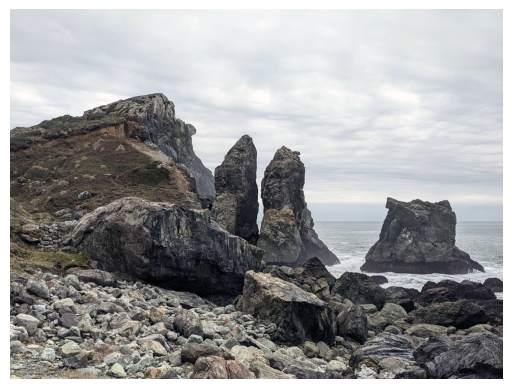

In [3]:
base_image_path = keras.utils.get_file("coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [4]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
layer_settings = {
  "mixed4": 1.0,
  "mixed5": 1.5,
  "mixed6": 2.0,
  "mixed7": 2.5,
}

outputs_dict = dict([
                      (layer.name, layer.output)
                      for layer in [model.get_layer(name)
                        for name in layer_settings.keys()]
                    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [6]:
def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
  return loss

In [9]:
import tensorflow as tf
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [10]:
@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image

In [11]:
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

In [12]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [13]:
import numpy as np
def preprocess_image(image_path):
  img = keras.utils.load_img(image_path)
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.inception_v3.preprocess_input(img)
  return img

In [14]:
def deprocess_image(img):
  img = img.reshape((img.shape[1], img.shape[2], 3))
  img /= 2.0
  img += 0.5
  img *= 255.
  img = np.clip(img, 0, 255).astype("uint8")
  return img

In [15]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)


/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.16
... Loss value at step 5: 2.48
... Loss value at step 6: 2.84
... Loss value at step 7: 3.21
... Loss value at step 8: 3.52
... Loss value at step 9: 3.93
... Loss value at step 10: 4.25
... Loss value at step 11: 4.61
... Loss value at step 12: 4.94
... Loss value at step 13: 5.31
... Loss value at step 14: 5.65
... Loss value at step 15: 6.02
... Loss value at step 16: 6.34
... Loss value at step 17: 6.62
... Loss value at step 18: 6.98
... Loss value at step 19: 7.33
... Loss value at step 20: 7.64
... Loss value at step 21: 7.97
... Loss value at step 22: 8.26
... Loss value at step 23: 8.55
... Loss value at step 24: 8.85
... Loss value at step 25: 9.16
... Loss value at step 26: 9.43
... Loss value at step 27: 9.72
... Loss value at step 28: 9.97
... Loss value at step 29: 10.29
Processing octave 1 with shape (642, 857)
... Los

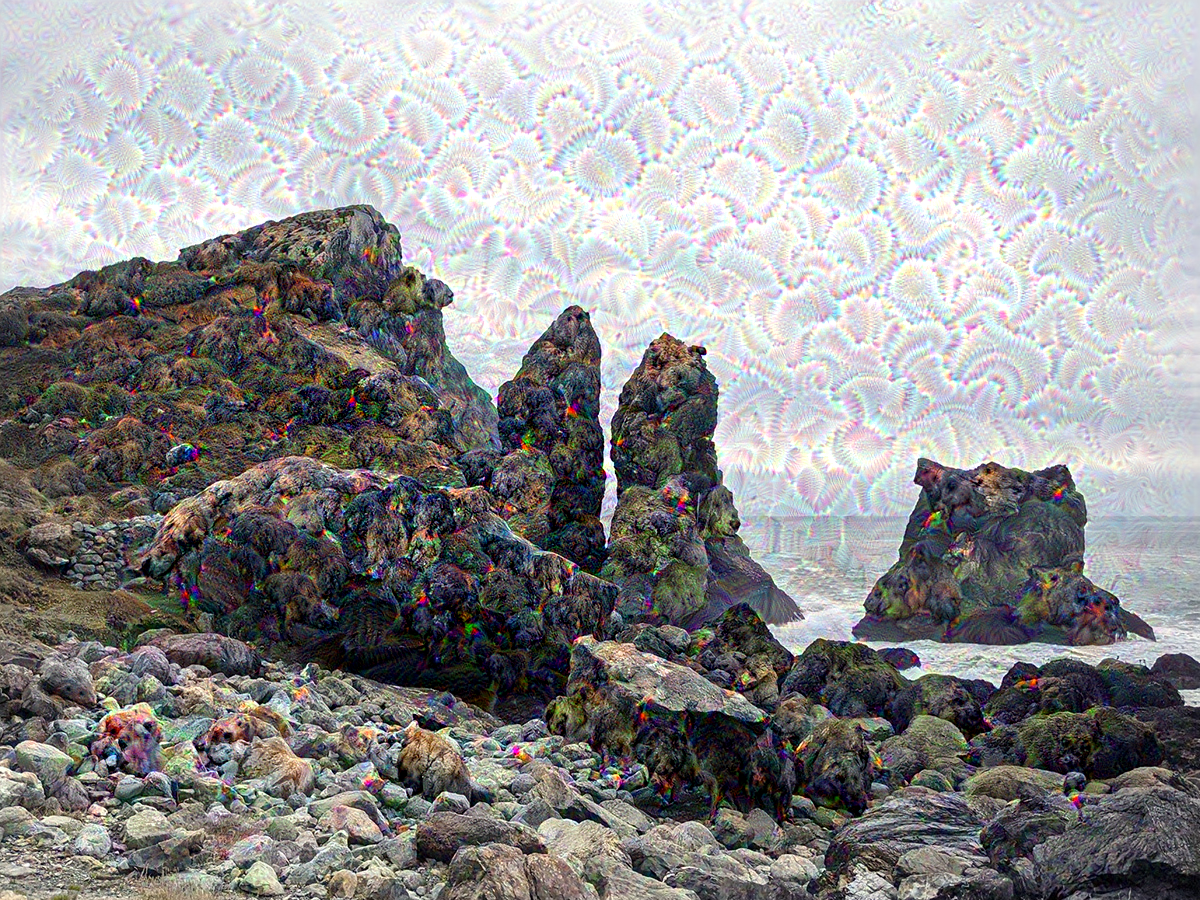

In [17]:
from PIL import Image
img = Image.open('dream.png')
img